# Unsupervised Learning
Dimensionality Reduction, Clustering, and Topic Modeling

In [1]:
# Used to plot UMAP using its own plotting function
# !pip install umap-learn[plot]
#  install in anaconda prompt: conda install -c numba/label/dev numba

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'numba/label/dev'


In [5]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import umap
# import umap.umap_ as umap
# import umap.plot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [6]:
# Adjust these values to change chart size
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

## Load Data
We can load our dataframes generated from our feature engineering steps

In [9]:
# Load training data
train_df = pickle.load(open('pkl/train_df.pkl','rb'))
# Load test data
test_df = pickle.load(open('pkl/test_df.pkl','rb'))

In [10]:
train_df.head()

,original_text,label,word_list,Word Counts,TTR,Dale Chall Sum,Passage Sum,Dale Chall Percent,SAT Sum,SAT Percent,...,perspicuity_index,smog_index,Pronoun Count,Pronoun Percent,sentence_embed,word_embed,Average_Embed,commune_matched,football_matched,LRB_RRB_matched
242608,The valley of the Ruwer is a part of the wine-...,0,"[valley, ruwer, part, wine, growing, region, m...","{'valley': 1, 'ruwer': 1, 'part': 1, 'wine-gro...",0.833333,3,10,0.300000,0,0.000000,...,102.768333,8.841846,0,0.0,"[0.17008887, 0.11635355, 0.17924389, 0.0727900...","[[0.6265286, 1.0881277, 0.89999634, -0.3027713...",-0.003312,0,0,0
375184,South of Flensburg and Flensburg wanted to sta...,0,"[south, flensburg, flensburg, wanted, stay, ge...","{'south': 1, 'flensburg': 3, 'want': 1, 'stay'...",0.809524,6,14,0.428571,0,0.000000,...,105.861316,3.129100,0,0.0,"[0.11654443, 0.1461171, 0.15022397, 0.20618439...","[[0.6395226, 1.2879447, 0.9390944, 0.011225526...",0.001187,0,0,0
324555,This led competing networks Smart Communicatio...,0,"[led, competing, networks, smart, communicatio...","{'lead': 1, 'compete': 1, 'network': 1, 'smart...",1.000000,4,12,0.333333,1,0.083333,...,81.810000,13.023867,0,0.0,"[0.20429334, 0.010100946, 0.0721706, 0.2348193...","[[-0.17948298, 0.65081435, 0.46374187, 0.61295...",0.009418,0,0,0
295820,List of acronyms and initialisms,0,"[list, acronyms, initialisms]","{'list': 1, 'acronym': 1, 'initialisms': 1}",1.000000,1,3,0.333333,0,0.000000,...,102.155000,8.841846,0,0.0,"[0.10136763, -0.1754802, 0.09219238, 0.2044126...","[[0.67263556, -0.07095434, -0.07983123, 0.6830...",-0.009143,0,0,0
245273,There are simple algorithms to calculate media...,0,"[simple, algorithms, calculate, median, mean, ...","{'simple': 1, 'algorithm': 1, 'calculate': 1, ...",0.904762,3,16,0.187500,0,0.000000,...,95.723235,11.208143,0,0.0,"[0.31198898, -0.11671565, 0.017236441, 0.18768...","[[0.76111686, -1.1256305, -0.20340267, 0.13263...",-0.000852,0,0,0


In [11]:
y_train = train_df["label"].to_numpy()

## Functions

In [13]:
def generate_plots(df,feature_list):
    """
    Takes in a dataframe and list of features and generates histograms based on the features.
    Each histogram consists of simple and complex feature distributions.
    
    Args:
    df -- The main dataframe that will be sliced by feature and complexity label.
    feature_list -- list of features to generate the histograms for.
    
    Returns:
    None -- Generates and shows plots only.
    
    """
    rows_0 = df[df["label"] == 0]
    rows_1 = df[df["label"] == 1]
    
    for feat in feature_list:
        x0 = rows_0[feat]
        x1 = rows_1[feat]

        fig = go.Figure()
        fig.add_trace(go.Histogram(x=x0,name="Simple"))
        fig.add_trace(go.Histogram(x=x1,name="Complex"))

        # Overlay both histograms
        fig.update_layout(width=600,height=400,barmode='overlay',title=go.layout.Title(text=f"Distribution of {feat} by Difficulty Label"))
        # Reduce opacity to see both histograms
        fig.update_traces(opacity=0.75)
        fig.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
        ))
        fig.show()
        
def get_imputed_array(df,from_save_path=None,save_to_path=None):
    """
    Takes in a df of training data and returns an imputed numpy array.
    Requires sklearn imputers.
    
    Args:
    df -- The original X data dataframe
    from_save_path -- Str of path where to load the saved file from if available
    save_to_path -- Str of path where to save the imputed array to.
    
    Returns:
    np.array -- Numpy array of imputed X data
    
    """
    
    if from_save_path:
        return np.load(from_save_path)
    else:
        arr = df.to_numpy()
        arr_imputed = KNNImputer(missing_values=np.nan, add_indicator=False).fit_transform(arr)
        if save_to_path:
            with open(save_to_path, 'wb') as f:
                np.save(f, arr_imputed)
        return arr_imputed
    
def get_normalized_data(df, path,load=True):
    """
    Load imputed numpy array and standardize it which is useful for traditional machine learning.
    
    Args:
    df -- df to use in get imputed array function.
    path -- path to load imputed array from
    load -- boolean value. If set to true, function will load imputed array from path.
    
    Returns:
    np.array -- Normalized & imputed numpy array of numerical features
        
    """
    if load:
        X_imputed = get_imputed_array(df,from_save_path=path,save_to_path=None)
        
    # If we can't load it from storage, we will compute the array and then save it.
    # Note: Resource intensive.
    
    else:
        X_imputed = get_imputed_array(df,from_save_path=None,save_to_path=path)
        
    X_train_normalized = StandardScaler().fit_transform(X_imputed)
    
    return X_train_normalized

def get_cluster_evaluation(X,y,clusters=[2,3,4,5,6]):
    
    """
    Loops through different number of possible clusters of Kmeans, evaluates them, and returns an evaluation df.
    
    Args:
    X -- Training data
    y -- True labels
    clusters -- list of integer values representing the number of clusters to evaluate.
    
    Returns:
    dataframe -- dataframe with each cluster value a row and various cluster evaluation metrics as columns.
    
    """
    
    adjusted_rand_scores = []
    homogeneity_scores = []
    completeness_scores = []
    v_measure_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    clusters = clusters
    
    for i in clusters:
        km = KMeans(n_clusters = i,  random_state = 42)
        cluster_labels = km.fit_predict(X)
        
        adjusted_rand_scores.append(adjusted_rand_score(y, cluster_labels))
        homogeneity_scores.append(metrics.homogeneity_score(y, cluster_labels))
        completeness_scores.append(metrics.completeness_score(y, cluster_labels))
        v_measure_scores.append(metrics.v_measure_score(y, cluster_labels))
        davies_bouldin_scores.append(metrics.davies_bouldin_score(X, cluster_labels))
        calinski_harabasz_scores.append(metrics.calinski_harabasz_score(X, cluster_labels))

    eval_df = pd.DataFrame({
        "clusters":clusters,
        "adjusted_rand_scores":adjusted_rand_scores,
        "completeness_scores":completeness_scores,
        "v_measure_scores":v_measure_scores,
        "davies_bouldin_scores":davies_bouldin_scores,
        "calinski_harabasz_scores":calinski_harabasz_scores
    })
    
    return eval_df

# TFIDF
def tfidf_data(text):
    """
    Takes in text data and transforms it to TFIDF representation.

    Args:
    text -- input list / series of text.

    returns:
    array -- spare numpy matrix of the transformed text
    list -- feature name list

    """
    tfidf_vec = TfidfVectorizer(stop_words="english")
    text_tfidf = tfidf_vec.fit_transform(text)
    tfidf_feature_names = tfidf_vec.get_feature_names()

    return text_tfidf,tfidf_feature_names

def get_topics_nmf(corpus,feature_names,num_topics=5,top_words=10):
    """
    Uses NMF to take in a corpus of text and prints list of topics.

    Args:
    corpus -- input text for the nmf model
    feature_names -- feature names of the vectorizer to match indices to words.
    n_components -- number of componenets for the nmf model (default 2)

    returns:
    None -- Prints out top topics only.

    """
  # Creates the model
    nmf_model = NMF(n_components=num_topics, init='nndsvd', random_state=42)
  # Extract W and H matrices
    W = nmf_model.fit_transform(corpus)
    H = nmf_model.components_

    # Extract topics - based on code from SIADS543
    for topic_index in range(0,num_topics):
        top_indices = np.argsort(H[topic_index,:])[::-1]
        top_terms = []
        for term_index in top_indices[0:top_words]:
            top_terms.append(tfidf_feature_names[term_index])
        print("topic ",topic_index, top_terms)
        
def plot_pca(pca, features, top_k = 2):
    """
    Plots magnitude of each feature for the top k components.
    Code directly from SIADS 543 Week 1 notebook.

    Args:
    pca -- pca object
    top_k -- number of principal components
    features -- list of feature names

    returns:
    None -- Prints out chart only   
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=features
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()

## Dimensionality Reduction and Data Visualization

In [14]:
# Numerical features to be used in certain models
features = ["automated_readability_index",
            "coleman_liau_index",
            "flesch_kincaid_grade_level",
            "flesch_reading_ease",
            "gunning_fog_index",
            "lix",
            "perspicuity_index",
            "smog_index",
            "Passage Sum",
            "Dale Chall Sum",
            "Dale Chall Percent",
            "SAT Sum",
            "SAT Percent",
            "AoA_Freq",
            "AoA_Mean_Age",
            "Conc.M",
            "Percent_known",
            "Average_Embed",
            "TTR",
            "Sqrd_AoA_Mean_Age",
            "Max_AoA_Age",
            "Min_AoA_Age",
            "Pronoun Count",
            "Pronoun Percent",
            "commune_matched",
            "football_matched",
            "LRB_RRB_matched"
]

In [16]:
# Loads imputed and normalized dataframe. If it doesn't exist, add False as third parameterto compute it and save it to the path specified.
imputed_path = "./pkl/X_imputed.npy"
X_normalized = get_normalized_data(train_df[features],imputed_path)

### PCA

In [17]:
# Fit PCA to our normalized data. We are using two principal components here for highest variance and visualization purposes.
# Code based on notebooks from SIADS 543.
pca = PCA(n_components = 2).fit(X_normalized)

# Transform data into PCA space with two principal components.
X_pca = pca.transform(X_normalized)

Text(0.5, 1.0, 'PCA Representation of Simple & Complex Sentences from Wikipedia')

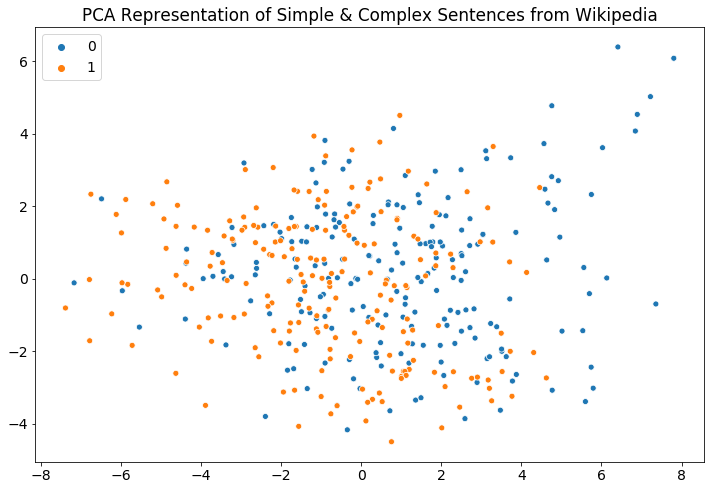

In [20]:
# Can plot PCA transformed data via seaborn
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=y_train).set_title(
    "PCA Representation of Simple & Complex Sentences from Wikipedia")

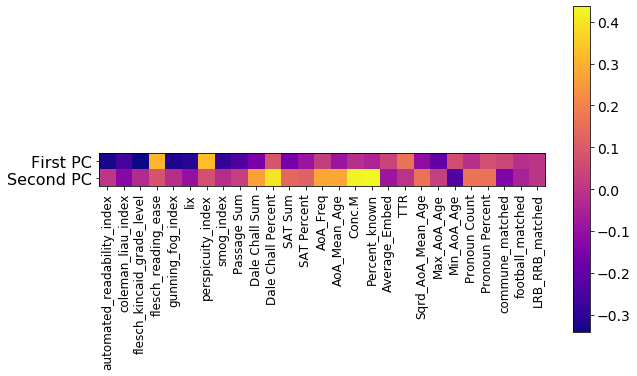

In [21]:
# We can plot the magnitude of features in relation to the top 2 principal components
plot_pca(pca,features)

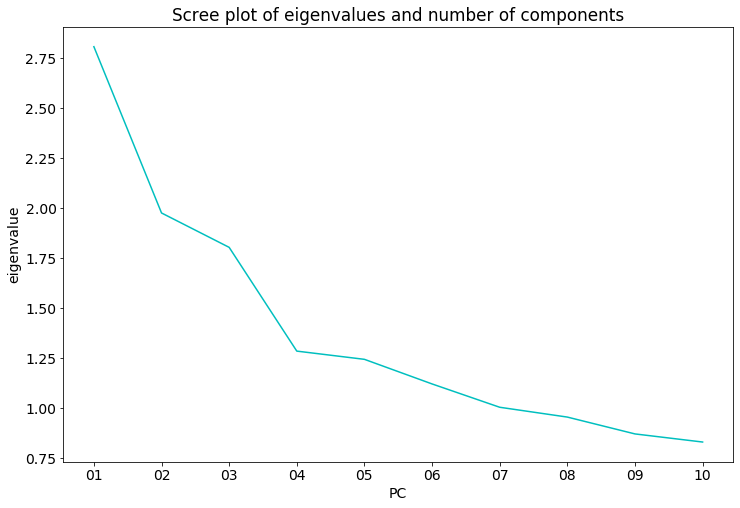

In [22]:
# Scree plot to check for optimal number of componenets. Code directly from SIADS 543 notebook.
pca = PCA(n_components = 10).fit(X_normalized)
scree_df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                   'PC':['01','02','03','04','05','06','07','08','09','10']})
sns.lineplot(x = 'PC',y = "eigenvalue", data = scree_df, color="c").set_title(
    "Scree plot of eigenvalues and number of components");

0    0.302175
1    0.451783
2    0.576458
3    0.639682
4    0.698922
5    0.747007
6    0.785593
7    0.820492
8    0.849497
9    0.875859
Name: explained var ratio, dtype: float64

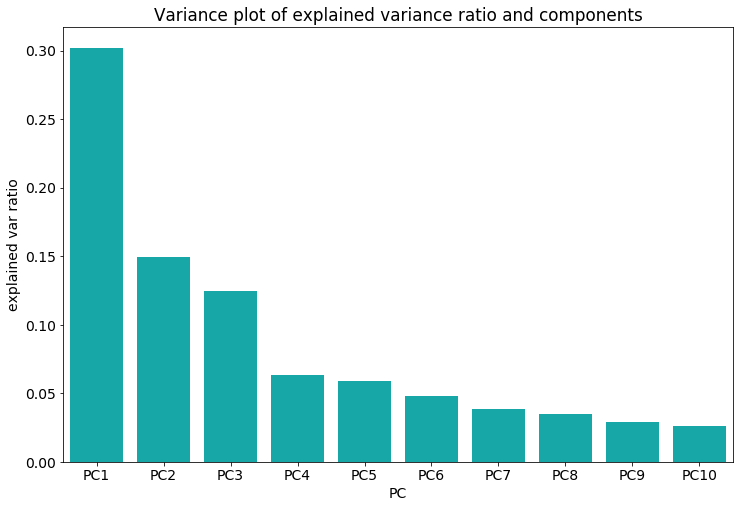

In [44]:
# Variance plot to check for optimal number of componenets. Code directly from SIADS 543 notebook.
variance_df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})
sns.barplot(x = 'PC',y = "explained var ratio", data = variance_df, color="c").set_title(
    "Variance plot of explained variance ratio and components");

# Show cumulative sum until we get an acceptable level of variance. 
# In our case, 2 components may not be enough. We would need 8 componenets to reach 80% explained variance.
np.cumsum(variance_df['explained var ratio'])

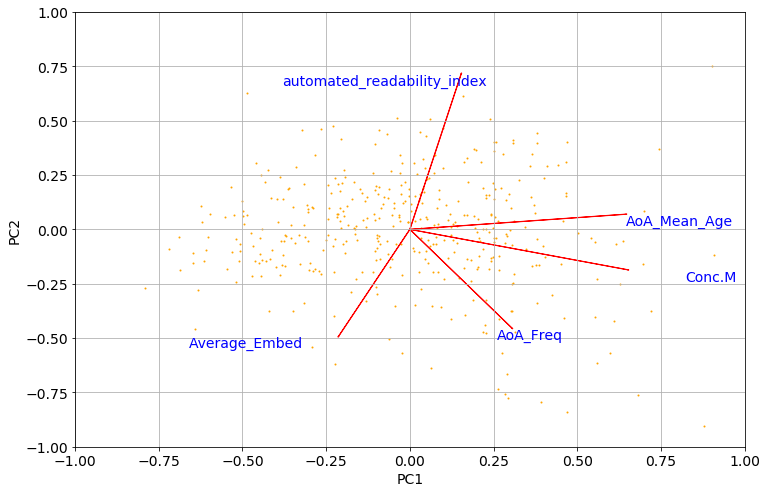

In [45]:
# We can plot our feature vectors in PCA space using a biplot.
# Code is from SIADS 543 using the pca library for plotting biplots easily.

def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.scatter(xs*scalex, ys*scaley, s=1, color= 'orange')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=1) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='b', ha='right', va='top')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='b', ha='right', va='top')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid(None)
plt.figure()
plt.rcParams["axes.grid"] = False
# Uncomment this code to generate the biplot using your previous answers
def create_bigram(df=train_df):
    # cols= ['TTR', 'Dale Chall Sum', 'Passage Sum', 'Dale Chall Percent', 'SAT Sum', 'SAT Percent', 'AoA_Freq', 'AoA_Mean_Age', 'Sqrd_AoA_Mean_Age', 'Max_AoA_Age', 'Min_AoA_Age', 'Conc.M', 'Conc.M_sqrd', 'Percent_known',  'Average_Embed', 'automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gunning_fog_index', 'lix', 'perspicuity_index', 'smog_index', 'Pronoun Count', 'Pronoun Percent', 'commune_boolean', 'football_boolean', 'commune_dummy', 'football_dummy', 'wiki_dummy', 'text_len']
    feature_names= ['Average_Embed','AoA_Freq','automated_readability_index','AoA_Mean_Age','Conc.M']
    df= df[feature_names].dropna()
    standard_df= StandardScaler().fit_transform(df)
    mod= PCA(2, random_state=0).fit(standard_df)
    X_pca = mod.transform(standard_df)
    biplot(X_pca, np.transpose(mod.components_[0:4, :]), 5, 1, 2, labels=feature_names)
create_bigram()

### UMAP

In [ ]:
%%time
# Can take a long time to run depending on parameters.
#inspired by umap's docs

# Fit UMAP
trans = umap.UMAP(n_neighbors=15, random_state=42, init="random",min_dist=0.7).fit(X_normalized)

# Transform our training data using UMAP
x_trans = trans.transform(X_normalized)

# Print out the shape. We have reduced dimensions to 2.
print(x_trans.shape)

In [ ]:
# Can plot via seaborn
sns.scatterplot(x=x_trans[:, 0], y=x_trans[:, 1],hue=y_train,s=1,alpha=0.1).set_title(
    "UMAP Representation of Simple & Complex Sentences from Wikipedia")

In [ ]:
# Alternative plotting method using UMAP's internal plotting function
# Our graph used in the report was edited to include a title
umap.plot.points(trans, labels=y_train, width=500, height=500, color_key_cmap='cividis')

Note: We attempted to use other methods such as Kernel PCA, MDS, or DBSCAN but faced resource and memory limitations.

## Clustering with KMeans

In [46]:
# Fit KMeans to our data. Using 2 clusters in an attempt to mimic our classification task of 2 labels.
# Note: We are not fitting this with labels included. This will be important for our next step.
kmeans = KMeans(n_clusters = 2,  random_state = 42)
kmeans.fit(X_normalized)

# We can also cluster based on our PCA or UMAP transformed data. Uncomment below to see the differences
# kmeans.fit(X_pca)
# kmeans.fit(x_trans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Was 2 clusters a good choice? We can evaluate KMeans using multiple metrics for different cluster values.

In [47]:
# Create evaluation dataframe and show it.
kmeans_eval_df = get_cluster_evaluation(X_normalized,y_train)
kmeans_eval_df

,clusters,adjusted_rand_scores,completeness_scores,v_measure_scores,davies_bouldin_scores,calinski_harabasz_scores
0,2,0.067673,0.051043,0.051043,1.911026,98.138252
1,3,0.038893,0.030254,0.036785,1.931132,75.634583
2,4,0.041633,0.029951,0.039289,2.063716,64.104103
3,5,0.030229,0.030877,0.042665,1.910733,57.448555
4,6,0.024828,0.031909,0.044682,1.728473,54.615571


Based on our evaluation dataframe, we can see that 2 clusters is an ideal choice. This is promising for our downstream task of classifying each sentence into 0 or 1. We can also perform silhouette analysis to see how well our cluster is doing.

In [48]:
# Return average silhouette score for 2 clusters.
# Based on scikit-learn tutorials.

silhouette_avg = silhouette_score(X_normalized,kmeans.labels_)
print("For n_clusters = 2 ",
      "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2  The average silhouette_score is : 0.17248169695469592


Our score for our total dataset is ~0.17 which is not great, but it is more than 0 which is promising. However, it is clear from our evaluation criteria as well as our data visualization steps such as PCA that there is heavy overlap in class labels.

We can test our KMeans predicted labels against the real training labels to see if they correlate.

In [49]:
# Create dataframe of true labels and predicted labels of the training data.
label_df = pd.DataFrame({"y_train":y_train,"kmeans_label":kmeans.labels_})

# Create a boolean value to check if the two labels are the same
label_df["are_same"] = label_df["y_train"] == label_df["kmeans_label"]

# Print out the number of values that are matching. 
# If they are imbalanced then it has picked up on some type of signal in the data.
label_df["are_same"].value_counts()

False    263
True     153
Name: are_same, dtype: int64

In [50]:
# The cluster labels are not guaranteed to be in the same order as the true labels, so we can switch the binary value.
# If the false matches are greater than the true matches, we can flip them to check for accuracy.
# As long as our accuracy is not 50/50 in either direction, it could be a useful feature.
if label_df["are_same"].value_counts()[False] > label_df["are_same"].value_counts()[True]:
    label_df["kmeans_label"] = label_df["kmeans_label"].replace({0:1, 1:0})

In [51]:
# Check for accuracy and F1 score of our KMeans predicted labels
acc = accuracy_score(label_df["y_train"],label_df["kmeans_label"])
f1 = f1_score(label_df["y_train"],label_df["kmeans_label"])

print(f"Accuracy score is {acc}")
print(f"F1 score is {f1}")

Accuracy score is 0.6322115384615384
F1 score is 0.6330935251798561


We can see that our KMeans cluster labels do show promise. They are 62% accurate on the training data.
Considering our training dataset is balanced in terms of labels, this means that the KMeans is reliably picking up on differences between the clusters which may make it a useful feature for our downstream classification task.

## Topic Modeling
One of our main questions was to see if topics differed based on label. We used TF-IDF and NMF topic modeling to investigate if this was the case.

In [52]:
# Slice dataframe into simple and complex based on their label. We only need the text column.
train_text_simple = train_df[train_df["label"] == 0]["original_text"]
train_text_complex = train_df[train_df["label"] == 1]["original_text"]

print(len(train_text_simple))
print(len(train_text_complex))

208
208


In [53]:
# Simple text topics
text_tfidf,tfidf_feature_names = tfidf_data(train_text_simple)
get_topics_nmf(corpus=text_tfidf,feature_names=tfidf_feature_names)

topic  0 ['rrb', 'lrb', 'born', 'player', 'april', 'american', 'basketball', 'districts', 'gross', 'december']
topic  1 ['calais', 'pas', 'department', 'region', 'france', 'north', 'nord', 'authie', 'raye', 'sur']
topic  2 ['capital', 'city', 'germany', 'bern', 'berlin', 'district', '10th', 'island', 'century', 'edinbourgh']
topic  3 ['football', 'club', 'english', 'scottish', 'stadium', 'statistics', 'crewe', 'norwich', 'stockport', 'county']
topic  4 ['commune', 'trangé', 'ryes', 'boyeux', 'saint', 'rã', 'romania', 'county', 'bosanci', 'suceava']


In [54]:
# Complex text topics
text_tfidf,tfidf_feature_names = tfidf_data(train_text_complex)
get_topics_nmf(corpus=text_tfidf,feature_names=tfidf_feature_names)

topic  0 ['lrb', 'rrb', 'brooklyn', '2003', 'confirmed', 'dodgers', 'joshua', 'period', 'born', 'january']
topic  1 ['commune', 'department', 'france', 'region', 'saint', 'western', 'aquitaine', 'gironde', 'basse', 'calvados']
topic  2 ['switzerland', 'canton', 'district', 'municipality', 'solothurn', 'lommiswil', 'bucheggberg', 'lebern', 'nennigkofen', 'uerkheim']
topic  3 ['game', 'series', 'video', 'known', 'zelda', 'katamari', 'kingdom', 'hearts', 'role', 'console']
topic  4 ['football', 'team', 'league', 'american', 'conference', 'nfl', 'afc', 'division', 'national', 'lrb']


In [55]:
### For test df which doesn't have labels by default
text_tfidf,tfidf_feature_names = tfidf_data(test_df["original_text"])
get_topics_nmf(corpus=text_tfidf,feature_names=tfidf_feature_names)

topic  0 ['lrb', 'rrb', 'born', 'football', 'channel', 'player', 'september', '16', '2007', 'o1986']
topic  1 ['released', 'july', 'album', 'aaliyah', '2001', 'final', 'queen', 'sls', 'terrorists', '1992']
topic  2 ['region', 'history', 'southern', 'department', 'commune', 'france', 'kingdom', 'pas', 'calais', 'uusimaa']
topic  3 ['state', 'saxony', 'district', 'germany', 'city', 'land', 'chemnitzer', 'free', 'anhalt', 'halle']
topic  4 ['new', 'york', 'national', 'engine', 'played', 'fifth', 'team', 'kress', 'hollywoods', 'citys']


Unfortunately, we did not observe any major differences in topics between labels, or even between the training and test data. Such topics did however inspire us (alongside our supervised learning failure analysis) to look more closely at the sentences to see what types of features or words may be common in predicting certain labels.